In [1]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

import xmitgcm as xm
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=4, cores=4, 
                     walltime='04:00:00')
w = cluster.scale(jobs=15)
#w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.25:43863 Dashboard: http://10.148.1.25:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

# load binary grid and store as a zarr archive

### generate mask file

In [16]:
mask_data_dir = '/home/c11-data/Test_aponte/aurelien/mit/'
ds = xm.open_mdsdataset(bin_grid_dir, grid_dir=bin_grid_dir,
                        iters=None, geometry='llc',
                        default_dtype=np.dtype('>f4'),
                        read_grid=True,
                        ignore_unknown_vars=True,
                        llc_method="smallchunks")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/xmitgcm/mds_store.py:845: UserWarning: Couldn't find available_diagnostics.log in /home/datawork-lops-osi/equinox/mit4320/bin/grid/ or /home/datawork-lops-osi/equinox/mit4320/bin/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [4]:
points = ['C', 'S', 'W']
ds_mask = (ds.reset_coords()[['mask'+p for p in points]]
           .rename({'mask'+p: 'mask_'+p.lower() for p in points})
          )
ds_mask

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask_c   (k, face, j, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    mask_s   (k, face, j_g, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    mask_w   (k, face, j, i_g) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/home/datawor...

In [ ]:
ds_mask.to_zarr(mask_path, mode='w', consolidated=True)

### store all but masks

In [9]:
ds = xm.open_mdsdataset(bin_grid_dir, grid_dir=bin_grid_dir,
                        iters=None, geometry='llc',
                        default_dtype=np.dtype('>f4'),
                        read_grid=True,
                        ignore_unknown_vars=True)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/xmitgcm/mds_store.py:845: UserWarning: Couldn't find available_diagnostics.log in /home/datawork-lops-osi/equinox/mit4320/bin/grid/ or /home/datawork-lops-osi/equinox/mit4320/bin/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [10]:
#ds_index, ds = get_compressed_level_index(grid_dir)

# we will need to keep some of these when computing gradients
#ds = ds.drop(['dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
ds = ds.drop(['hFacC','hFacW','hFacS'])
ds = ds.drop(['maskC','maskW','maskS'])
#ds = ds.drop(['Z', 'Zp1', 'Zu', 'Zl', 'drC', 'drF','PHrefC','PHrefF'])

#Nc = 432 # original choice
#Nc = 27 # very long scheduling
#Nc = 96 # 96*45
#ds = ds.chunk({'i': Nc, 'j': Nc, 'i_g': Nc, 'j_g': Nc})

print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG      

In [19]:
%time ds.to_zarr(zarr_grid, mode='w')

CPU times: user 13.8 s, sys: 48 s, total: 1min 1s
Wall time: 11.2 s


--- 

# standard data layout: chunks (face, time, j, i) = (1, 1, 4320, 4320)

In [3]:
# map variables to variables known by llcreader (kind of a hack)
vmap = {'Eta': 'Eta', 
        'SST': 'SDIAG1', 'SSS':'SDIAG2', 
        'SSU':'SDIAG9', 'SSV':'SDIAG10',
        'SIarea': 'SIarea', 'SIheff': 'SIheff'}

In [8]:
# generate useful symbolic links:
for v, vd in vmap.items():
    src = glob(os.path.join(root_data_dir,'bin',v+'/'+v+'*.shrunk'))
    for s in src:
        dest = os.path.join(root_data_dir,'bin/all', vd+'.'+s.split('/')[-1].split('.')[1]+'.data.shrunk')
        if not os.path.isfile(dest):
            os.symlink(s, dest)

In [17]:
# open data store
bpath = os.path.join(root_data_dir,'bin/all/')

fs = LocalFileSystem()
store = llcreader.BaseStore(fs, base_path=bpath, 
                            shrunk=True, mask_path=mask_path)
model = llcreader.LLC4320Model(store)

In [18]:
# get iters for each variables
def get_iter(filename):
    return int(filename.split('/')[-1].split('.')[1])

I = {}
for v, vd in vmap.items():
    files = sorted(glob(os.path.join(root_data_dir,'bin/all/'+vd+'*.data.shrunk')))
    I[v] = [get_iter(files[0]), get_iter(files[-1])]
I

{'Eta': [10368, 1495008],
 'SST': [228096, 1492992],
 'SSS': [228096, 1492992],
 'SSU': [228096, 1492992],
 'SSV': [228096, 1492992],
 'SIarea': [10368, 1495008],
 'SIheff': [10368, 1495008]}

In [19]:
# load one data set

#V = ['Eta', 'SST', 'SSS']
V = ['SSU', 'SSV', 'SIarea', 'SIheff']
#V = ['oceTAUX', 'oceTAUY', 'KPPhbl']

di = 144 # hourly values
#di = 144*24 # daily values

v = V[1]
ds = model.get_dataset(varnames=[vmap[v]], 
                       iter_start=I[v][0], 
                       iter_stop=I[v][1]+1, 
                       iter_step=di, 
                       )
ds = ds.chunk({'face': 1})
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 8785)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 dask.array<chunksize=(8785,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
Data variables:
    SDIAG10  (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [20]:
# investigates one crash
# SIheff 9  data is 0.0GB 

block = 200
v = 'SIheff'
i = 9

ds = model.get_dataset(varnames=[vmap[v]], 
                       iter_start=I[v][0], 
                       iter_stop=I[v][1]+1, 
                       iter_step=di)
ds = ds.rename({vmap[v]:v})
ds = ds.chunk({'face': 1})
tblock = np.arange(0,ds.niter.size,block)
it = tblock[i]

dv = ds[v].isel(time=slice(it,it+block)).to_dataset()

In [22]:
dv_mean = dv.mean('time').persist()

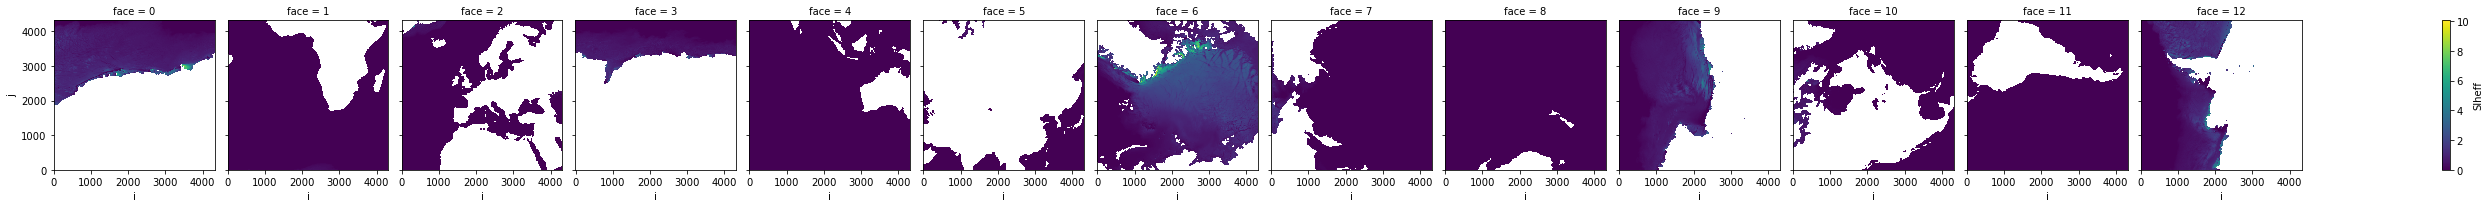

In [23]:
dv_mean.SIheff.isel(i=slice(0,None,4),j=slice(0,None,4)).plot(col='face')

In [24]:
file_out = zarr_data_dir+'%s_%02d.zarr'%(v,i)
try:
    #%time delayed = dv.to_zarr(file_out, mode='w', compute=False)                    
    dv.to_zarr(file_out, mode='w')
except:
    print('Failure')

dsize = getsize(file_out)


In [25]:
V = ['SIheff']

In [7]:
# tmp, need to process by block of files
block = 200

for v in V:
    
    ds = model.get_dataset(varnames=[vmap[v]], 
                           iter_start=I[v][0], 
                           iter_stop=I[v][1]+1, 
                           iter_step=di)
    ds = ds.rename({vmap[v]:v})
    ds = ds.chunk({'face': 1})
    
    tblock = np.arange(0,ds.niter.size,block)
    for i, it in enumerate(tblock):

        dv = ds[v].isel(time=slice(it,it+block)).to_dataset()

        file_out = zarr_data_dir+'%s_%02d.zarr'%(v,i)
        try:
            #%time delayed = dv.to_zarr(file_out, mode='w', compute=False)                    
            dv.to_zarr(file_out, mode='w')
        except:
            print('Failure')

        dsize = getsize(file_out)
        print('{} {}  data is {:.1f}GB ' .format(v, i, dsize/1e9))

SSU 0  data is 91.7GB 
SSU 1  data is 91.4GB 
SSU 2  data is 92.3GB 
SSU 3  data is 92.2GB 
SSU 4  data is 92.1GB 
SSU 5  data is 92.0GB 
SSU 6  data is 91.4GB 
SSU 7  data is 92.0GB 
SSU 8  data is 92.0GB 
SSU 9  data is 91.7GB 
SSU 10  data is 92.4GB 
SSU 11  data is 92.0GB 
SSU 12  data is 92.4GB 
SSU 13  data is 92.4GB 
SSU 14  data is 91.9GB 
SSU 15  data is 91.8GB 
SSU 16  data is 92.5GB 
SSU 17  data is 92.0GB 
SSU 18  data is 92.3GB 
SSU 19  data is 92.3GB 
SSU 20  data is 91.7GB 
SSU 21  data is 92.2GB 
SSU 22  data is 91.6GB 
SSU 23  data is 92.9GB 
SSU 24  data is 91.4GB 
SSU 25  data is 91.9GB 
SSU 26  data is 91.7GB 
SSU 27  data is 92.4GB 
SSU 28  data is 91.7GB 
SSU 29  data is 91.4GB 
SSU 30  data is 92.1GB 
SSU 31  data is 91.8GB 
SSU 32  data is 92.4GB 
SSU 33  data is 92.0GB 
SSU 34  data is 92.4GB 
SSU 35  data is 91.9GB 
SSU 36  data is 92.0GB 
SSU 37  data is 92.0GB 
SSU 38  data is 91.8GB 
SSU 39  data is 91.7GB 
SSU 40  data is 91.8GB 
SSU 41  data is 92.0GB 
SS

In [26]:
# reload and merge
for v in V:
    print('--- {}'.format(v))
    zarr_archives = sorted(glob(zarr_data_dir+'%s_*.zarr'%(v)))
    ds = xr.concat([xr.open_zarr(z) for z in zarr_archives], dim='time')
    file_out = zarr_data_dir+'%s.zarr'%(v)
    %time ds.to_zarr(file_out, mode='w')

--- SIheff
CPU times: user 9min 45s, sys: 18.3 s, total: 10min 3s
Wall time: 17min 58s


In [27]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


---

## processing full dataset does not go through at the moment

In [5]:
# does not go through at the moment: workers freeze eventually
for v in V:
    dv = ds[v].to_dataset()
    
    file_out = zarr_data_dir+'%s.zarr'%(v)
    try:
        #%time delayed = dv.to_zarr(file_out, mode='w', compute=False)                    
        %time dv.to_zarr(file_out, mode='w')
    except:
        print('Failure')
        
    dsize = getsize(file_out)
    print('   data is %.1fGB ' %(dsize/1e9))    

CPU times: user 28 ms, sys: 88 ms, total: 116 ms
Wall time: 2.16 s
   data is 0.0GB 


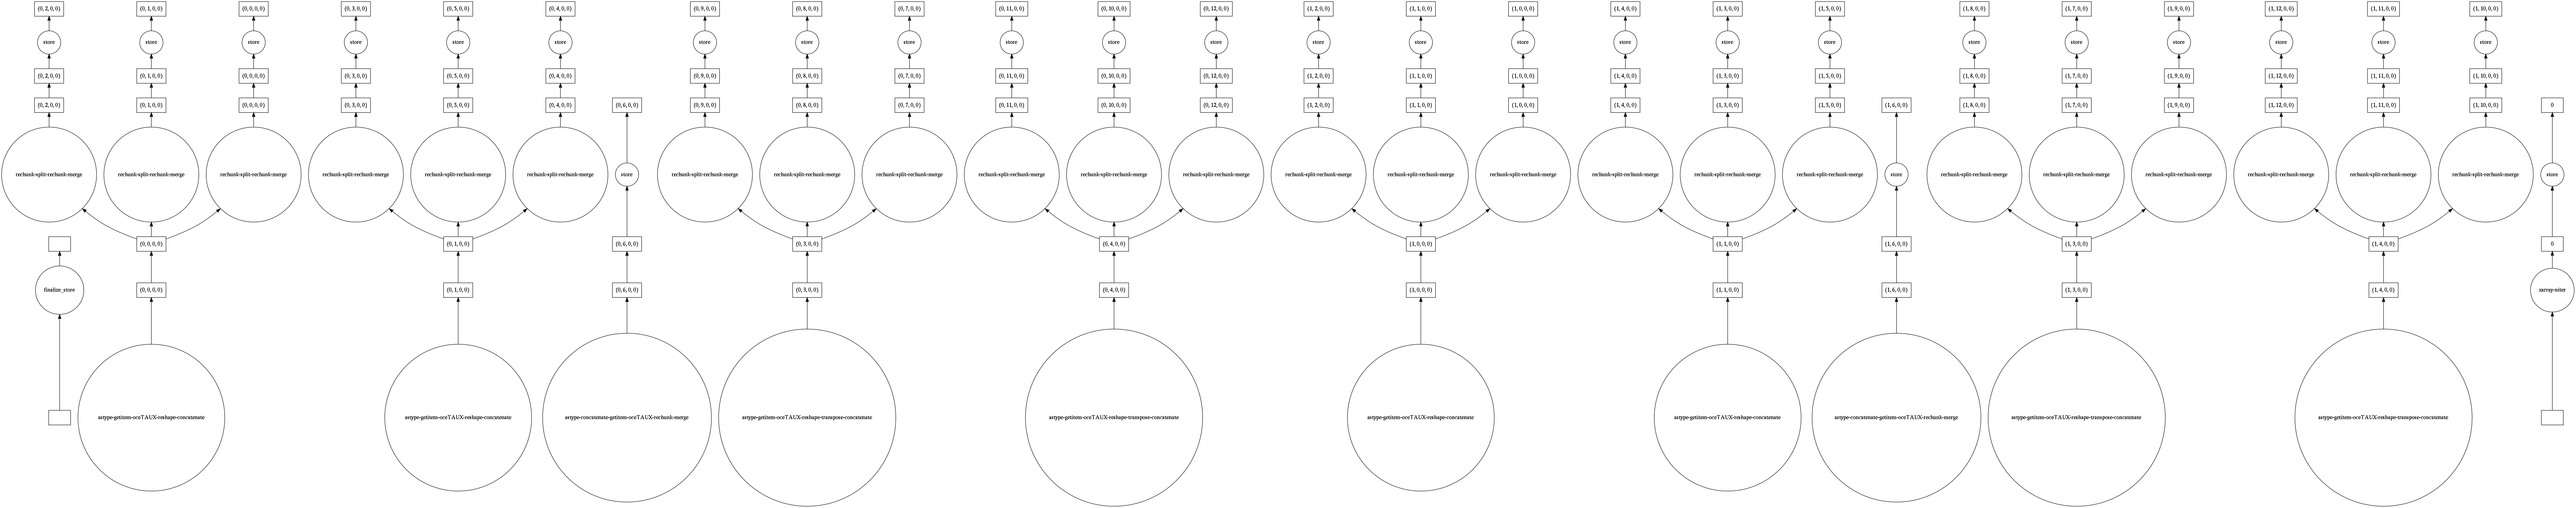

In [6]:
delayed.visualize()

In [20]:
ds.oceTAUX.data.dask

In [ ]:
ds.oceTAUX.data.dask.items()

In [9]:
ds.nbytes/1e9

7188.084893336

In [23]:
# check file existence
if False:
    niter = ds.niter.values
    for n in niter:
        _file = bpath+'oceTAUX.%0.10d.data.shrunk'%n
        if not os.path.isfile(_file):
            print(_file)

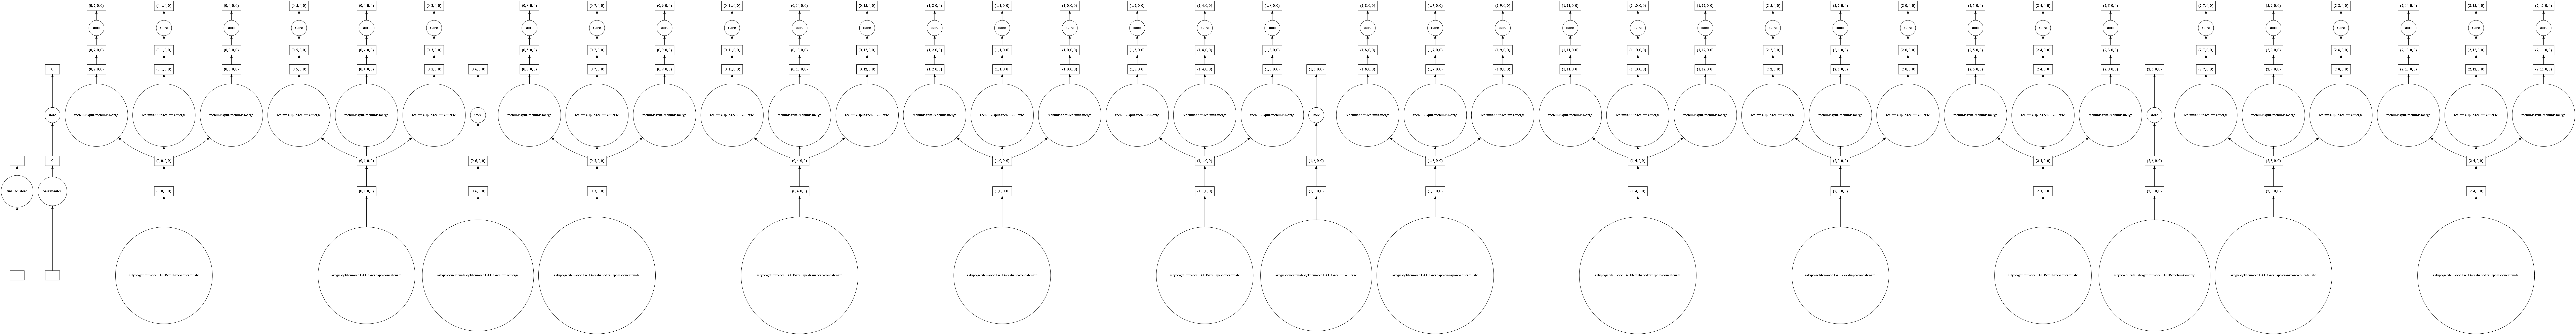

---
## inspect result

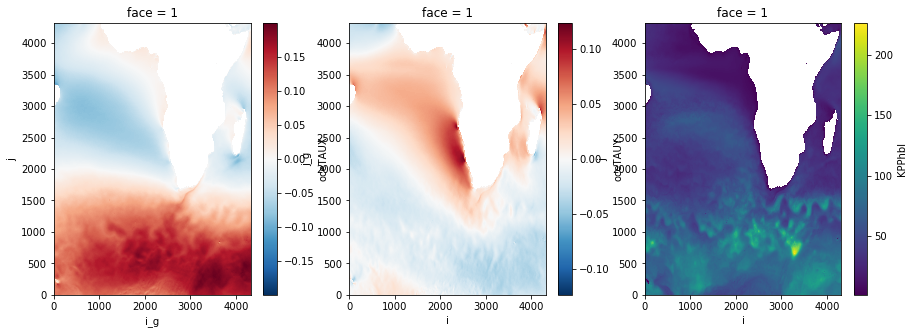

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
for v, ax in zip(V, axs):
    ds = xr.open_zarr(zarr_data_dir+'%s.zarr'%(v))
    ds.isel(face=1)[v].mean('time').plot(ax=ax)

---

In [13]:
cluster.close()

---

## debug

In [3]:
import dask.array as da
x = da.random.random((int(1e6), int(1e6)), chunks=(5000, 5000))
print('Size in GB: %.1f'%(x.nbytes/1e9))

Size in GB: 8000.0


In [6]:
bpath = root_data_dir+'tmp/'
x.to_zarr(bpath+'test.zarr', overwrite=True)

In [ ]:
client.restart()

In [15]:
cluster.scale(20)

In [26]:
cluster.close()